# Common

In [ ]:
import os
import numpy as np
from sklearn import neighbors as knn
from glob import glob
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from sklearn.metrics import balanced_accuracy_score
import itertools
import dlib
from sklearn.model_selection import GridSearchCV
import pandas as pd
from joblib import parallel_backend

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_DIR = '/content/drive/MyDrive/dl_for_cv/data/lfw'

# Labeled Faces in the Wild

Labeled Faces in the Wild is a database of face photographs designed for studying the problem of unconstrained face recognition. The data set contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. See [homepage](http://vis-www.cs.umass.edu/lfw/).

In [ ]:
%cd '/content/drive/MyDrive/dl_for_cv/data/'

/content/drive/MyDrive/dl_for_cv/data


In [ ]:
!wget http://vis-www.cs.umass.edu/lfw/lfw.tgz

--2021-10-31 18:29:37--  http://vis-www.cs.umass.edu/lfw/lfw.tgz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180566744 (172M) [application/x-gzip]
Saving to: ‘lfw.tgz’

lfw.tgz             100%[===================>] 172.20M  40.4MB/s    in 4.5s    

2021-10-31 18:29:41 (38.5 MB/s) - ‘lfw.tgz’ saved [180566744/180566744]



In [ ]:
!tar -xzf lfw.tgz

# Dataset preparation

In [ ]:
DB_RATIO = 0.2

In [ ]:
persons = []
person_qs = []

for person in sorted(os.listdir(DATA_DIR)):
    persons.append(person)
    person_qs.append(len(glob(os.path.join(DATA_DIR, person, '*.jpg'))))
    
persons = np.asarray(persons)
person_qs = np.asarray(person_qs)

print(persons.size, person_qs.size)

5753 5753


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


(0.0, 40.0)

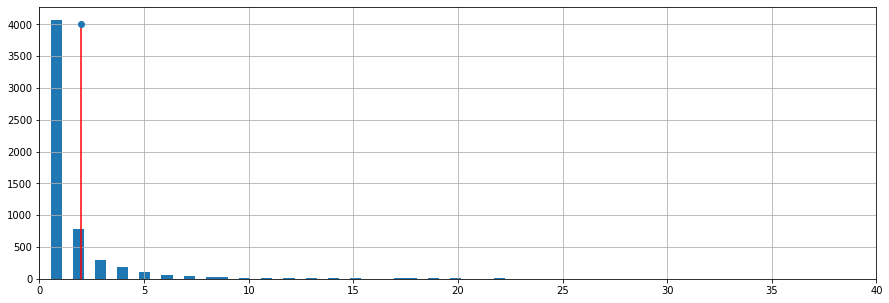

In [ ]:
plt.figure(figsize=(15, 5))
plt.hist(person_qs, bins=1000)
plt.stem([2], [4000], 'r')
plt.grid(True)

plt.xlim(0, 40)

In [ ]:
person_qs[person_qs > 2].sum() / person_qs.sum()

0.5747751832539862

In [ ]:
persons_known = persons[person_qs > 2]
persons_unkonwn = persons[person_qs <= 2]

print(persons_known.size, persons_unkonwn.size, persons_known.size + persons_unkonwn.size)

901 4852 5753


In [ ]:
person_to_id = {}
for p_id, person in enumerate(sorted(persons_known)):
    person_to_id[person] = p_id

In [ ]:
person_to_id

{'Aaron_Peirsol': 0,
 'Abdoulaye_Wade': 1,
 'Abdullah': 2,
 'Abdullah_Gul': 3,
 'Abdullah_al-Attiyah': 4,
 'Abel_Pacheco': 5,
 'Abid_Hamid_Mahmud_Al-Tikriti': 6,
 'Adam_Sandler': 7,
 'Adel_Al-Jubeir': 8,
 'Adolfo_Aguilar_Zinser': 9,
 'Adrien_Brody': 10,
 'Ahmed_Chalabi': 11,
 'Ai_Sugiyama': 12,
 'Aicha_El_Ouafi': 13,
 'Akbar_Hashemi_Rafsanjani': 14,
 'Akhmed_Zakayev': 15,
 'Al_Gore': 16,
 'Al_Pacino': 17,
 'Al_Sharpton': 18,
 'Alan_Greenspan': 19,
 'Alastair_Campbell': 20,
 'Albert_Costa': 21,
 'Alec_Baldwin': 22,
 'Alejandro_Avila': 23,
 'Alejandro_Toledo': 24,
 'Aleksander_Kwasniewski': 25,
 'Alex_Sink': 26,
 'Alexander_Downer': 27,
 'Alexander_Losyukov': 28,
 'Alexandra_Stevenson': 29,
 'Ali_Khamenei': 30,
 'Ali_Naimi': 31,
 'Allyson_Felix': 32,
 'Alvaro_Noboa': 33,
 'Alvaro_Silva_Calderon': 34,
 'Alvaro_Uribe': 35,
 'Amanda_Bynes': 36,
 'Amelia_Vega': 37,
 'Amelie_Mauresmo': 38,
 'Amer_al-Saadi': 39,
 'Ana_Guevara': 40,
 'Ana_Palacio': 41,
 'Anastasia_Myskina': 42,
 'Anders_Ebbeson

In [ ]:
files_db, ids_db = [], []
files_query, ids_query = [], []

for person in persons_known:
    _id = person_to_id[person]
    files = sorted(glob(os.path.join(DATA_DIR, person, '*.jpg')))
    
    l = len(files)
    q = int(np.ceil(l * DB_RATIO))
    
    files_db.extend(files[:q])
    ids_db.extend([_id] * q)
    
    files_query.extend(files[q:])
    ids_query.extend([_id] * (l - q))
    
for person in persons_unkonwn:
    files = sorted(glob(os.path.join(DATA_DIR, person, '*.jpg')))
    
    files_query.extend(files)
    ids_query.extend([np.NaN] * len(files))
    
files_db = np.asarray(files_db)
ids_db = np.asarray(ids_db)

files_query = np.asarray(files_query)
ids_query = np.asarray(ids_query)

print(files_db.size, ids_db.size)
print(files_query.size, ids_query.size)

1823 1823
11410 11410


# 1st-level predictor

In [ ]:
%cd /content/drive/MyDrive/dl_for_cv/

/content/drive/MyDrive/dl_for_cv


Our 1st-level predictor (aka embedding generator). Essentially this is ResNet-50 slighlty modified for REID heads. See [origin](https://github.com/TreB1eN/InsightFace_Pytorch) and big thanks authors for their work!

In [ ]:
FACE_SIZE = 112

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

*Model definition from [this file](https://github.com/TreB1eN/InsightFace_Pytorch/blob/master/model.py).*

In [ ]:
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, Sigmoid, Dropout, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module
from collections import namedtuple

class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def l2_norm(input,axis=1):
    norm = torch.norm(input,2,axis,True)
    output = torch.div(input, norm)
    return output

class SEModule(Module):
    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = AdaptiveAvgPool2d(1)
        self.fc1 = Conv2d(
            channels, channels // reduction, kernel_size=1, padding=0 ,bias=False)
        self.relu = ReLU(inplace=True)
        self.fc2 = Conv2d(
            channels // reduction, channels, kernel_size=1, padding=0 ,bias=False)
        self.sigmoid = Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x

class bottleneck_IR(Module):
    def __init__(self, in_channel, depth, stride):
        super(bottleneck_IR, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride ,bias=False), BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3, 3), (1, 1), 1 ,bias=False), PReLU(depth),
            Conv2d(depth, depth, (3, 3), stride, 1 ,bias=False), BatchNorm2d(depth))

    def forward(self, x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)
        return res + shortcut

class bottleneck_IR_SE(Module):
    def __init__(self, in_channel, depth, stride):
        super(bottleneck_IR_SE, self).__init__()
        if in_channel == depth:
            self.shortcut_layer = MaxPool2d(1, stride)
        else:
            self.shortcut_layer = Sequential(
                Conv2d(in_channel, depth, (1, 1), stride ,bias=False), 
                BatchNorm2d(depth))
        self.res_layer = Sequential(
            BatchNorm2d(in_channel),
            Conv2d(in_channel, depth, (3,3), (1,1),1 ,bias=False),
            PReLU(depth),
            Conv2d(depth, depth, (3,3), stride, 1 ,bias=False),
            BatchNorm2d(depth),
            SEModule(depth,16)
            )
    def forward(self,x):
        shortcut = self.shortcut_layer(x)
        res = self.res_layer(x)
        return res + shortcut

class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
    '''A named tuple describing a ResNet block.'''
    
def get_block(in_channel, depth, num_units, stride = 2):
  return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units-1)]

def get_blocks(num_layers):
    if num_layers == 50:
        blocks = [
            get_block(in_channel=64, depth=64, num_units = 3),
            get_block(in_channel=64, depth=128, num_units=4),
            get_block(in_channel=128, depth=256, num_units=14),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 100:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=13),
            get_block(in_channel=128, depth=256, num_units=30),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    elif num_layers == 152:
        blocks = [
            get_block(in_channel=64, depth=64, num_units=3),
            get_block(in_channel=64, depth=128, num_units=8),
            get_block(in_channel=128, depth=256, num_units=36),
            get_block(in_channel=256, depth=512, num_units=3)
        ]
    return blocks

class Backbone(Module):
    def __init__(self, num_layers, drop_ratio, mode='ir'):
        super(Backbone, self).__init__()
        assert num_layers in [50, 100, 152], 'num_layers should be 50,100, or 152'
        assert mode in ['ir', 'ir_se'], 'mode should be ir or ir_se'
        blocks = get_blocks(num_layers)
        if mode == 'ir':
            unit_module = bottleneck_IR
        elif mode == 'ir_se':
            unit_module = bottleneck_IR_SE
        self.input_layer = Sequential(Conv2d(3, 64, (3, 3), 1, 1 ,bias=False), 
                                      BatchNorm2d(64), 
                                      PReLU(64))
        self.output_layer = Sequential(BatchNorm2d(512), 
                                       Dropout(drop_ratio),
                                       Flatten(),
                                       Linear(512 * 7 * 7, 512),
                                       BatchNorm1d(512))
        modules = []
        for block in blocks:
            for bottleneck in block:
                modules.append(
                    unit_module(bottleneck.in_channel,
                                bottleneck.depth,
                                bottleneck.stride))
        self.body = Sequential(*modules)
    
    def forward(self,x):
        x = self.input_layer(x)
        x = self.body(x)
        x = self.output_layer(x)
        return l2_norm(x)

Model weights are from [here](https://github.com/TreB1eN/InsightFace_Pytorch#32-detect-over-camera). **Please download it manually**.

In [ ]:
model = Backbone(50, 0.0, mode='ir_se').eval()
model.load_state_dict(torch.load('model_ir_se50.pth'))
model.cuda()

Backbone(
  (input_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=64)
  )
  (output_layer): Sequential(
    (0): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Dropout(p=0.0, inplace=False)
    (2): Flatten()
    (3): Linear(in_features=25088, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (body): Sequential(
    (0): bottleneck_IR_SE(
      (shortcut_layer): MaxPool2d(kernel_size=1, stride=2, padding=0, dilation=1, ceil_mode=False)
      (res_layer): Sequential(
        (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (2): PReLU(num_parameters=64)
        (3)

*This one is not related to the repo..*

In [ ]:
def gen_embds(fs):
    embds = []
    for f in tqdm(fs):
        img = dlib.load_rgb_image(f)

        dets = face_detector(img)
        if len(dets) == 0:
            embds.append(np.zeros((512,)))  
            continue
            
        landmarks = shape_predictor(img, dets[0])
        face_crop = dlib.get_face_chip(img, landmarks, size=FACE_SIZE, padding=0.3)[:, :, [2, 1, 0]]

        with torch.no_grad():
            embd = model(transform(face_crop).unsqueeze(0).cuda())[0]
        embds.append(embd.cpu().numpy())
        
    return np.asarray(embds)

See [this](http://dlib.net/face_detector.py.html) cookbook for `dlib` face detection or [this one](http://dlib.net/face_alignment.py.html) for face alignment.

In [ ]:
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bunzip2 shape_predictor_5_face_landmarks.dat.bz2

In [ ]:
face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

Let's detect faces and generate embeddings:

In [ ]:
embds_db = gen_embds(files_db)
embds_query = gen_embds(files_query)

print(embds_db.shape, ids_db.shape)
print(embds_query.shape, ids_query.shape)

  0%|          | 0/1823 [00:00<?, ?it/s]

  0%|          | 0/11410 [00:00<?, ?it/s]

(1823, 512) (1823,)
(11410, 512) (11410,)


In [ ]:
inds = np.abs(embds_db).sum(axis=1) > 0

embds_db = embds_db[inds]
ids_db = ids_db[inds]

print(embds_db.shape, ids_db.shape)

(5358, 512) (5358,)


In [ ]:
inds = np.abs(embds_query).sum(axis=1) > 0

embds_query = embds_query[inds]
ids_query = ids_query[inds]

print(embds_query.shape, ids_query.shape)

(7817, 512) (7817,)


Just sanity check:

In [ ]:
assert np.unique(ids_db).size == ids_db.max() + 1

Save embeddings in the appropriate format for the further analysis in the Embedding Projector:

In [ ]:
f_data = open('arface_lfw.tsv', 'w')

for embd in embds_db:
    f_data.write('\t'.join([str(round(v, 4)) for v in embd]) + '\n')
    
f_data.flush()
f_data.close()

In [ ]:
f_meta = open('arface_lfw_meta.tsv', 'w')

for _id in ids_db:
    f_meta.write('person{}\n'.format(int(_id)))
    
f_meta.flush()
f_meta.close()

Store embeddings itself in order not to process the dataset every time:

In [ ]:
np.save(os.path.join(DATA_DIR, 'embds_db'), embds_db)
np.save(os.path.join(DATA_DIR, 'ids_db'), ids_db)

In [ ]:
np.save(os.path.join(DATA_DIR, 'embds_query'), embds_query)
np.save(os.path.join(DATA_DIR, 'ids_query'), ids_query)

# 2nd-level predictor

In [ ]:
def cosine_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

In [ ]:
def cosine_dist(v1, v2):
    return 1 - cosine_sim(v1, v2)

In [ ]:
def euc_dist(v1, v2):
    return np.linalg.norm(v1 - v2)

*(you can find them into numpy / scipy / sklearn etc)*

In [ ]:
embds_db = np.load(os.path.join(DATA_DIR, 'embds_db.npy'))
ids_db = np.load(os.path.join(DATA_DIR, 'ids_db.npy'))

print(embds_db.shape, ids_db.shape)

(1818, 512) (1818,)


In [ ]:
embds_query = np.load(os.path.join(DATA_DIR, 'embds_query.npy'))
ids_query = np.load(os.path.join(DATA_DIR, 'ids_query.npy'))

print(embds_query.shape, ids_query.shape)

(11357, 512) (11357,)


In [ ]:
search_params = {
    'n_neighbors': [1, 3, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', cosine_dist]
}
predictor = knn.KNeighborsClassifier(n_jobs=-1)
classifier = GridSearchCV(predictor, search_params, n_jobs=-1, verbose=3)

In [ ]:
classifier.fit(embds_db, ids_db)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.2min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=-1,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'metric': ['minkowski',
                                    <function cosine_dist at 0x7fa4d0533290>],
                         'n_neighbors': [1, 3, 5],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=3)

In [ ]:
classifier.best_score_

0.5874685920140467

In [ ]:
classifier.best_params_

{'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'uniform'}

In [ ]:
df = pd.DataFrame.from_dict(classifier.cv_results_)

print(df.shape)

(12, 16)


In [ ]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_metric,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.133665,0.031476,0.715505,0.049128,minkowski,1,uniform,"{'metric': 'minkowski', 'n_neighbors': 1, 'wei...",0.574176,0.587912,0.582418,0.611570,0.581267,0.587469,0.012820,1
1,0.191334,0.018370,0.652827,0.046142,minkowski,1,distance,"{'metric': 'minkowski', 'n_neighbors': 1, 'wei...",0.574176,0.587912,0.582418,0.611570,0.581267,0.587469,0.012820,1
2,0.138134,0.040214,0.709559,0.075478,minkowski,3,uniform,"{'metric': 'minkowski', 'n_neighbors': 3, 'wei...",0.472527,0.469780,0.478022,0.476584,0.468320,0.473047,0.003756,9
3,0.106962,0.018986,0.769785,0.043743,minkowski,3,distance,"{'metric': 'minkowski', 'n_neighbors': 3, 'wei...",0.565934,0.582418,0.560440,0.600551,0.570248,0.575918,0.014286,6
4,0.098216,0.011198,0.756027,0.050288,minkowski,5,uniform,"{'metric': 'minkowski', 'n_neighbors': 5, 'wei...",0.436813,0.447802,0.445055,0.449036,0.438017,0.443345,0.005025,11
5,0.165045,0.040681,0.655099,0.070196,minkowski,5,distance,"{'metric': 'minkowski', 'n_neighbors': 5, 'wei...",0.524725,0.554945,0.535714,0.578512,0.539945,0.546768,0.018597,8
6,0.328539,0.080421,14.948638,0.162923,<function cosine_dist at 0x7fa4d0533290>,1,uniform,{'metric': <function cosine_dist at 0x7fa4d053...,0.574176,0.587912,0.582418,0.611570,0.581267,0.587469,0.012820,1
7,0.403910,0.044779,15.007868,0.173767,<function cosine_dist at 0x7fa4d0533290>,1,distance,{'metric': <function cosine_dist at 0x7fa4d053...,0.574176,0.587912,0.582418,0.611570,0.581267,0.587469,0.012820,1
8,0.414994,0.038927,15.176381,0.234721,<function cosine_dist at 0x7fa4d0533290>,3,uniform,{'metric': <function cosine_dist at 0x7fa4d053...,0.472527,0.469780,0.478022,0.476584,0.468320,0.473047,0.003756,9
9,0.448147,0.023278,14.972891,0.183084,<function cosine_dist at 0x7fa4d0533290>,3,distance,{'metric': <function cosine_dist at 0x7fa4d053...,0.565934,0.582418,0.560440,0.600551,0.573003,0.576469,0.014109,5


In [ ]:
for i_p, p in enumerate(classifier.cv_results_['params']):
    print('{}: {}'.format(i_p, p))

0: {'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'uniform'}
1: {'metric': 'minkowski', 'n_neighbors': 1, 'weights': 'distance'}
2: {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'uniform'}
3: {'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'distance'}
4: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}
5: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
6: {'metric': <function cosine_dist at 0x7fa4d0533290>, 'n_neighbors': 1, 'weights': 'uniform'}
7: {'metric': <function cosine_dist at 0x7fa4d0533290>, 'n_neighbors': 1, 'weights': 'distance'}
8: {'metric': <function cosine_dist at 0x7fa4d0533290>, 'n_neighbors': 3, 'weights': 'uniform'}
9: {'metric': <function cosine_dist at 0x7fa4d0533290>, 'n_neighbors': 3, 'weights': 'distance'}
10: {'metric': <function cosine_dist at 0x7fa4d0533290>, 'n_neighbors': 5, 'weights': 'uniform'}
11: {'metric': <function cosine_dist at 0x7fa4d0533290>, 'n_neighbors': 5, 'weights': 'distance'}


In [ ]:
dist_f = cosine_dist

In [ ]:
classifier = knn.KNeighborsClassifier(n_neighbors=1, metric=dist_f, n_jobs=-1)
classifier.fit(embds_db, ids_db)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
                     metric=<function cosine_dist at 0x7f668cf77290>,
                     metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
                     weights='uniform')

In [ ]:
with parallel_backend('threading', n_jobs=-1):
  ids_pred = classifier.predict(embds_query)

print(ids_pred.shape)

(11357,)


In [ ]:
idx_known = ~np.isnan(ids_query)
idx_unknown = np.isnan(ids_query)

In [ ]:
print(balanced_accuracy_score(ids_query[idx_known], ids_pred[idx_known]))

0.725058065693951


# Evaluation

## Prerequisites

In [ ]:
def plot_hists(dists_pos, dists_other, dists_neg, nbins=100):
    plt.figure(figsize=(15, 5))

    plt.hist(dists_pos, color='r', bins=nbins, alpha=0.5, label='positive')
    plt.hist(dists_other, color='g', bins=nbins, alpha=0.5, label='other')
    plt.hist(dists_neg, color='b', bins=nbins, alpha=0.5, label='negative')

    plt.legend(fontsize=14)
    plt.grid(True)

In [ ]:
def plot_far_frr(xs, ys, thrs):
    plt.figure(figsize=(15, 5))

    plt.plot(xs, ys, 'r')
    plt.grid(True)

    for x, y in zip(xs, ys):
        plt.stem([x], [y], 'k--')
    for i, thr in enumerate(thrs):
        plt.text(
            xs[i], ys[i] + 0.01, str(round(thr, 2)),
            horizontalalignment='center', verticalalignment='bottom', fontsize=14, fontweight='bold'
    )

    plt.xlabel('FAR', fontsize=18)
    plt.ylabel('FRR', fontsize=18)

    plt.tick_params(labelsize=14)

In [ ]:
def plot_thresholds(xs, ys, thrs):
    plt.figure(figsize=(15, 5))

    plt.plot(thrs, xs, 'b', label='FAR', linewidth=2.0)
    plt.plot(thrs, ys, 'g', label='FRR', linewidth=2.0)
    plt.grid(True)

    plt.xlabel('threshold (distance)', fontsize=18)
    plt.ylabel('rate', fontsize=18)

    plt.legend(fontsize=14)
    plt.tick_params(labelsize=14)

## Embedding analysis

In [ ]:
dmtx_db_query = np.empty((len(ids_db), len(ids_query)))

for i_db, embd_db in enumerate(tqdm(embds_db)):
    for i_query, embd_query in enumerate(embds_query):
        dmtx_db_query[i_db, i_query] = dist_f(embd_db, embd_query)
        
print(dmtx_db_query.shape)

  0%|          | 0/1818 [00:00<?, ?it/s]

(1818, 11357)


In [ ]:
idx_pred = dmtx_db_query.argmin(0)
ids_pred_ = np.asarray([ids_db[_id] for _id in idx_pred])

In [ ]:
(ids_pred[idx_known] - ids_pred_[idx_known]).sum()

0

In [ ]:
dists_pos, dists_other, dists_neg = [], [], []

for c in tqdm(np.unique(ids_db)):
    embds_pos = embds_query[ids_query == c]
    idx = np.arange(len(embds_pos))
    for id1, id2 in itertools.combinations(idx, 2):
        dist = dist_f(embds_pos[id1], embds_pos[id2])
        dists_pos.append(dist)
        
    embds_other = embds_query[(idx_known) & (ids_query != c)]
    for embd_pos in embds_pos:
        for embd_other in embds_other:
            dist = dist_f(embd_pos, embd_other)
            dists_other.append(dist)
        
dists_neg = dmtx_db_query[:, idx_unknown].flatten()
        
print(len(dists_pos), len(dists_other), len(dists_neg))

  0%|          | 0/899 [00:00<?, ?it/s]

151597 32822584 10178982


In [ ]:
np.random.shuffle(dists_pos)
np.random.shuffle(dists_other)
np.random.shuffle(dists_neg)

In [ ]:
min_q = min(len(dists_pos), len(dists_other), len(dists_neg))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


<StemContainer object of 3 artists>

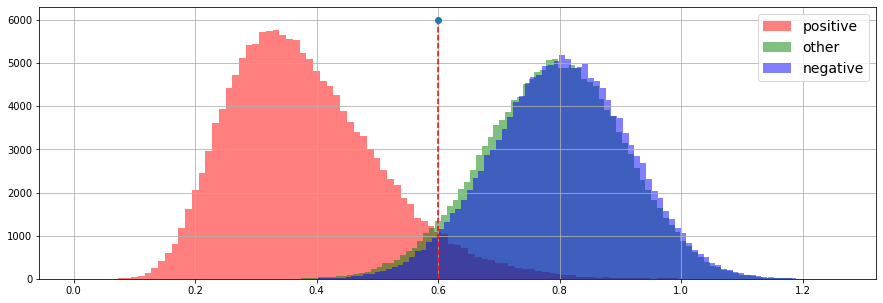

In [ ]:
plot_hists(dists_pos[:min_q], dists_other[:min_q], dists_neg[:min_q], nbins=100)
plt.stem([0.6], [6000], 'r--')

## FAR/FRR

In [ ]:
thrs = np.linspace(0.3, 0.8, 11)

In [ ]:
thrs

array([0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ])

In [ ]:
fars, frrs = [], []

dsts_pred = dmtx_db_query.min(0)
print(dsts_pred.shape)

for thr in tqdm(thrs):
    far = (dsts_pred[idx_unknown] <= thr).sum() / len(ids_query)
    fars.append(far)
    
    frr = (dsts_pred[idx_known] > thr).sum() / len(ids_query)
    frrs.append(frr)

#     break

fars = np.asarray(fars)
frrs = np.asarray(frrs)

print(fars.shape, frrs.shape)

(11357,)


  0%|          | 0/11 [00:00<?, ?it/s]

(11,) (11,)


In [ ]:
fars

array([0.00088051, 0.00651581, 0.04807608, 0.18658096, 0.35326231,
       0.45610637, 0.48666021, 0.49203135, 0.49273576, 0.49299991,
       0.49299991])

In [ ]:
frrs

array([2.95940829e-01, 2.07096945e-01, 1.32869596e-01, 6.70951836e-02,
       2.44782953e-02, 5.81139385e-03, 1.05661706e-03, 1.76102844e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


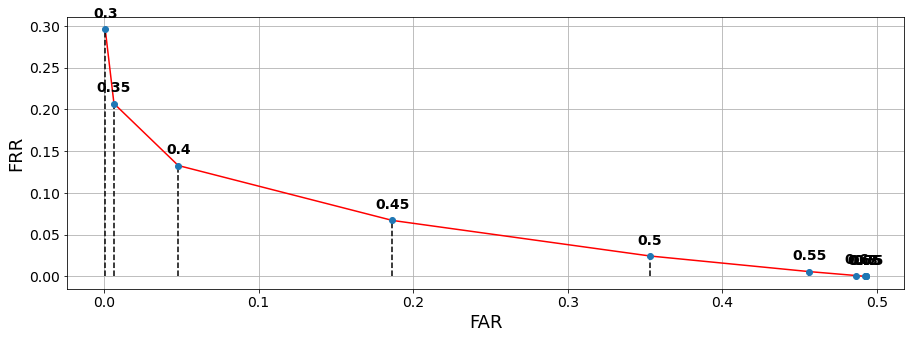

In [ ]:
plot_far_frr(fars, frrs, thrs)

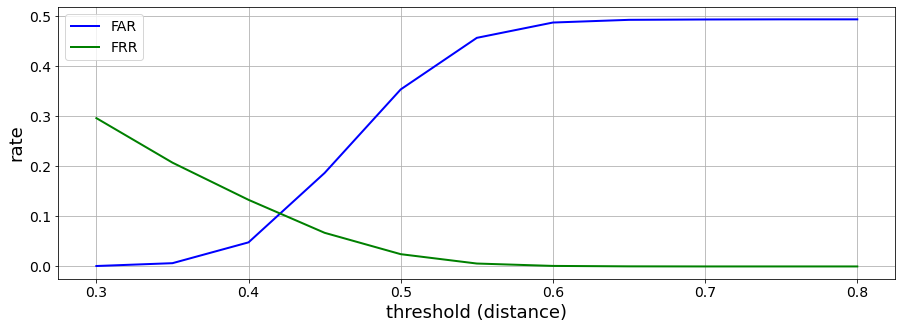

In [ ]:
plot_thresholds(fars, frrs, thrs)